In [77]:
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import networkx as nx

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Alienware\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Loading and accessing tweets

In the video, we loaded a tweet we collected using tweepy into Python (to do!). Tweets arrive from the Streaming API in JSON format and need to be converted into a Python data structure.

In this exercise, we'll load a single tweet into Python and print out some fields.

In [2]:
def save_and_load_json(json_file, json_dict=False, to_dict=False):
    
    if json_dict:
        
        if to_dict:
            json_dict = json.loads(json_dict)

        with open(json_file, "w") as file:
            json.dump(json_dict, file, indent=4)
    
    with open(json_file, "r") as file:
        return json.load(file)

In [3]:
tweet = save_and_load_json(json_file = 'tweet_json.json', json_dict=False, to_dict=False)
tweet

{'created_at': 'Thu Apr 19 14:25:04 +0000 2018',
 'id': 986973961295720449,
 'id_str': '986973961295720449',
 'text': "Writing out the script of my @DataCamp class and I can't help but mentally read it back to myself in @hugobowne's voice.",
 'truncated': False,
 'entities': {'hashtags': [],
  'symbols': [],
  'user_mentions': [{'screen_name': 'DataCamp',
    'name': 'DataCamp',
    'id': 1568606814,
    'id_str': '1568606814',
    'indices': [29, 38]},
   {'screen_name': 'hugobowne',
    'name': 'Hugo Bowne-Anderson',
    'id': 1092509048,
    'id_str': '1092509048',
    'indices': [101, 111]}],
  'urls': []},
 'metadata': {'iso_language_code': 'en', 'result_type': 'recent'},
 'in_reply_to_status_id': None,
 'in_reply_to_status_id_str': None,
 'in_reply_to_user_id': None,
 'in_reply_to_user_id_str': None,
 'in_reply_to_screen_name': None,
 'user': {'id': 661613,
  'id_str': '661613',
  'name': 'Alex Hanna, Data Witch',
  'screen_name': 'alexhanna',
  'location': 'Toronto, ON',
  'desc

In [4]:
# Print tweet text
print(tweet['text'])

# Print tweet id
print(tweet['id'])

Writing out the script of my @DataCamp class and I can't help but mentally read it back to myself in @hugobowne's voice.
986973961295720449


In [5]:
# Print user handle
print(tweet['user']['screen_name'])

# Print user follower count
print(tweet['user']['followers_count'])

# Print user location
print(tweet['user']['location'])

# Print user description
print(tweet['user']['description'])

alexhanna
4267
Toronto, ON
Assistant professor @UofT. Protest, media, computation. Trans. Roller derby athlete @TOROLLERDERBY (Kate Silver #538). She/her.


Accessing retweet data

Now we're going to work with a tweet JSON that contains a retweet. A retweet has the same structure as a regular tweet, except that it has another tweet stored in retweeted_status.

The new tweet has been loaded as rt.

In [6]:
rt = save_and_load_json(json_file = 'rt.json', json_dict=False, to_dict=False)
rt

{'created_at': 'Thu Apr 19 12:45:59 +0000 2018',
 'id': 986949027123154944,
 'id_str': '986949027123154944',
 'text': "RT @hannawallach: ICYMI: NIPS/ICML/ICLR are looking for a full-time programmer to run the conferences' submission/review processes. More in…",
 'truncated': False,
 'entities': {'hashtags': [],
  'symbols': [],
  'user_mentions': [{'screen_name': 'hannawallach',
    'name': 'Hanna Wallach',
    'id': 823957466,
    'id_str': '823957466',
    'indices': [3, 16]}],
  'urls': []},
 'metadata': {'iso_language_code': 'en', 'result_type': 'recent'},
 'in_reply_to_status_id': None,
 'in_reply_to_status_id_str': None,
 'in_reply_to_user_id': None,
 'in_reply_to_user_id_str': None,
 'in_reply_to_screen_name': None,
 'user': {'id': 661613,
  'id_str': '661613',
  'name': 'Alex Hanna, Data Witch',
  'screen_name': 'alexhanna',
  'location': 'Toronto, ON',
  'description': 'Assistant professor @UofT. Protest, media, computation. Trans. Roller derby athlete @TOROLLERDERBY (Kate Sil

In [7]:
# Print the text of the tweet
print(rt['text'])

# Print the text of tweet which has been retweeted
print(rt['retweeted_status']['text'])

# Print the user handle of the tweet
print(rt['user']['screen_name'])

# Print the user handle of the tweet which has been retweeted
print(rt['retweeted_status']['user']['screen_name'])

RT @hannawallach: ICYMI: NIPS/ICML/ICLR are looking for a full-time programmer to run the conferences' submission/review processes. More in…
ICYMI: NIPS/ICML/ICLR are looking for a full-time programmer to run the conferences' submission/review processes. M… https://t.co/aB9Y5tTyHT
alexhanna
hannawallach


Tweet Items and Tweet Flattening

There are multiple fields in the Twitter JSON which contains textual data. In a typical tweet, there's the tweet text, the user description, and the user location. In a tweet longer than 140 characters, there's the extended tweet child JSON. And in a quoted tweet, there's the original tweet text and the commentary with the quoted tweet.

For this exercise, you'll extract textual elements from a single quoted tweet in which the original tweet has more than 140 characters. Then, to analyze tweets at scale, we will want to flatten the tweet JSON into a single level. This will allow us to store the tweets in a DataFrame format.

In [8]:
quoted_tweet = save_and_load_json(json_file = 'quoted_tweet.json', json_dict=False, to_dict=False)
quoted_tweet

{'created_at': 'Wed Apr 25 17:20:04 +0000 2018',
 'id': 989192330832891904,
 'id_str': '989192330832891904',
 'text': 'maybe if I quote tweet this lil guy https://t.co/BzbLDz9j6g',
 'display_text_range': [0, 35],
 'source': '<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>',
 'truncated': False,
 'in_reply_to_status_id': None,
 'in_reply_to_status_id_str': None,
 'in_reply_to_user_id': None,
 'in_reply_to_user_id_str': None,
 'in_reply_to_screen_name': None,
 'user': {'id': 661613,
  'id_str': '661613',
  'name': 'Alex Hanna, Data Witch',
  'screen_name': 'alexhanna',
  'location': 'Toronto, ON',
  'url': 'http://alex-hanna.com',
  'description': 'Assistant professor @UofT. Protest, media, computation. Trans. Roller derby athlete @TOROLLERDERBY (Kate Silver #538). She/her.',
  'translator_type': 'regular',
  'protected': False,
  'verified': False,
  'followers_count': 4275,
  'friends_count': 2806,
  'listed_count': 246,
  'favourites_count': 23526,


In [9]:
# Print the tweet text
print(quoted_tweet['text'])

# Print the quoted tweet text
print(quoted_tweet['quoted_status']['text'])

# Print the quoted tweet's extended (140+) text
print(quoted_tweet['quoted_status']['extended_tweet']['full_text'])

# Print the quoted user location
print(quoted_tweet['quoted_status']['user']['location'])

maybe if I quote tweet this lil guy https://t.co/BzbLDz9j6g
O 280 characters, 280 characters! Wherefore art thou 280 characters?
Deny thy JSON and refuse thy key.
Or, if thou… https://t.co/MlFg4qFnEC
O 280 characters, 280 characters! Wherefore art thou 280 characters?
Deny thy JSON and refuse thy key.
Or, if thou wilt not, be but sworn my love,
And I’ll no longer be a 140 character tweet.
Toronto, ON


In [10]:
# Store the user screen_name in 'user-screen_name'
quoted_tweet['user-screen_name'] = quoted_tweet['quoted_status']['user']['screen_name']

# Store the quoted_status text in 'quoted_status-text'
quoted_tweet['quoted_status-text'] = quoted_tweet['quoted_status']['text']

# Store the quoted tweet's extended (140+) text in 
# 'quoted_status-extended_tweet-full_text'
quoted_tweet['quoted_status-extended_tweet-full_text'] = quoted_tweet['quoted_status']['extended_tweet']['full_text']

A tweet flattening function

We are typically interested in hundreds or thousands of tweets. For this purpose, it makes sense to define a function to flatten JSON file full of tweets. Let's call this function flatten_tweets(). We will use this function multiple times in this course and change it slightly as we deal with different types of data.

In [11]:
 def flatten_tweets(tweets_json):
    tweets = []
    
    # Iterate through each tweet
    for tweet in tweets_json:

        tweet_obj = json.loads(tweet)

        # Store the user screen name in 'user-screen_name'
        tweet_obj['user-screen_name'] = tweet_obj['user']['screen_name']
    
        # Check if this is a 140+ character tweet
        if 'extended_tweet' in tweet_obj:
            # Store the extended tweet text in 'extended_tweet-full_text'
            tweet_obj['extended_tweet-full_text'] = tweet_obj['extended_tweet']['full_text']
    
        if 'retweeted_status' in tweet_obj:
            # Store the retweet user screen name in 'retweeted_status-user-screen_name'
            tweet_obj['retweeted_status-user-screen_name'] = tweet_obj['retweeted_status']['user']['screen_name']
            # Store the retweet text in 'retweeted_status-text'
            tweet_obj['retweeted_status-text'] = tweet_obj['retweeted_status']['text']
            if 'extended_tweet' in tweet_obj['retweeted_status']:
                # Store the extended retweet text in 'retweeted_status-extended_tweet-full_text'
                tweet_obj['retweeted_status-extended_tweet-full_text'] = tweet_obj['retweeted_status']['extended_tweet']['full_text']
                
        if 'quoted_status' in tweet_obj:
            tweet_obj['quoted_status-text'] = tweet_obj['quoted_status']['text']
            if 'extended_tweet' in tweet_obj['quoted_status']:
                tweet_obj['quoted_status-extended_tweet-full_text'] = tweet_obj['quoted_status']['extended_tweet']['full_text']
                
        if 'user' in tweet_obj:
            if 'location' in tweet_obj['user']:
                tweet_obj['user-location'] = tweet_obj['user']['location']
            
        tweets.append(tweet_obj)
    return tweets

Loading tweets into a DataFrame

Now it's time to import data into a pandas DataFrame so we can analyze tweets at scale.

We will work with a dataset of tweets which contain the hashtag '#rstats' or '#python'. This dataset is stored as a list of tweet JSON objects in data_science_json.

In [12]:
data_science_json = save_and_load_json(json_file = 'data_science_json.json', json_dict=False, to_dict=False)

In [13]:
# Flatten the tweets and store in `tweets`
tweets = flatten_tweets(data_science_json)

# Create a DataFrame from `tweets`
ds_tweets = pd.DataFrame(tweets)

print(ds_tweets.shape)
ds_tweets

(375, 43)


,created_at,id,id_str,text,source,truncated,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,...,possibly_sensitive,extended_entities,extended_tweet,extended_tweet-full_text,display_text_range,quoted_status_id,quoted_status_id_str,quoted_status,quoted_status-text,quoted_status-extended_tweet-full_text
0,Fri Mar 30 13:04:22 +0000 2018,979705897457942528,979705897457942528,RT @Dennboss: Hahahah Efteling maakt Maxi-Cosi...,"<a href=""http://twitter.com/download/android"" ...",False,NaN,None,NaN,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Fri Mar 16 11:59:09 +0000 2018,974616055006941184,974616055006941184,RT @PythonWeekly: Python Weekly - Issue 338 ht...,"<a href=""http://twitter.com/download/iphone"" r...",False,NaN,None,NaN,None,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Tue Mar 27 08:34:33 +0000 2018,978550832273805312,978550832273805312,"RT @dataandme: ICYMI, still 💜ing this: ""Where ...","<a href=""http://twitter.com/download/iphone"" r...",False,NaN,None,NaN,None,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Fri Mar 16 21:26:58 +0000 2018,974758950737448960,974758950737448960,RT @dataandme: 🕴@jaredlander knows how to put ...,"<a href=""http://twitter.com/download/android"" ...",False,NaN,None,NaN,None,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Thu Mar 15 23:35:05 +0000 2018,974428804494995456,974428804494995456,RT @llanga: I heard it's Py Day today so I mad...,"<a href=""http://twitter.com/download/iphone"" r...",False,NaN,None,NaN,None,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370,Tue Mar 13 08:23:25 +0000 2018,973474600326696960,973474600326696960,RT @tkb: Want to tell stories about global dev...,"<a href=""http://twitter.com/download/android"" ...",False,NaN,None,NaN,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
371,Sat Mar 03 17:42:59 +0000 2018,969991541233209344,969991541233209344,Самый дешёвый CDN из всех что я знаю https://t...,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",False,NaN,None,NaN,None,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
372,Fri Mar 16 07:46:03 +0000 2018,974552360302272513,974552360302272513,RT @json_stack: python json.loads Unterminated...,"<a href=""http://twitter.com/download/android"" ...",False,NaN,None,NaN,None,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
373,Sun Mar 25 23:36:39 +0000 2018,978053077403095042,978053077403095042,RT @KKulma: My last blog post on hints how to ...,"<a href=""http://twitter.com/download/android"" ...",False,NaN,None,NaN,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Finding keywords

Counting known keywords is one of the first ways you can analyze text data in a Twitter dataset. In this dataset, you're going to count the number of times specific hashtags occur in a collection of tweets about data science. To this end, you're going to use the string methods in the pandas Series object to do this.

In [14]:
# Find mentions of #python in 'text'
python = ds_tweets['text'].str.contains('#python', case=False)

python

0      False
1       True
2      False
3      False
4       True
       ...  
370    False
371     True
372     True
373    False
374    False
Name: text, Length: 375, dtype: bool

In [15]:
# Print proportion of tweets mentioning #python
print("Proportion of #python tweets:", np.sum(python) / ds_tweets.shape[0])

Proportion of #python tweets: 0.44533333333333336


Looking for text in all the wrong places

Recall that relevant text may not only be in the main text field of the tweet. It may also be in the extended_tweet, the retweeted_status, or the quoted_status. We need to check all of these fields to make sure we've accounted for all the of the relevant text. We'll do this often so we're going to create a function which does this.

In [16]:
def check_word_in_tweet(word, data):
    """Checks if a word is in a Twitter dataset's text. 
    Checks text and extended tweet (140+ character tweets) for tweets,
    retweets and quoted tweets.
    Returns a logical pandas Series.
    """
    contains_column = data['text'].str.contains(word, case = False)
    contains_column |= data['extended_tweet-full_text'].str.contains(word, case = False)
    contains_column |= data['quoted_status-text'].str.contains(word, case = False)
    contains_column |= data['quoted_status-extended_tweet-full_text'].str.contains(word, case = False)
    contains_column |= data['retweeted_status-text'].str.contains(word, case = False)
    contains_column |= data['retweeted_status-extended_tweet-full_text'].str.contains(word, case = False)
    return contains_column

Comparing #python to #rstats

Now that we have a function to check whether or not the word is in the tweet in multiple places, we can deploy this across multiple words and compare them. Let's return to our example with the data science hashtag dataset. We want to see how many times that #rstats occurs compared to #python.

In [17]:
# Find mentions of #python in all text fields
python = check_word_in_tweet('#python', ds_tweets)

# Find mentions of #rstats in all text fields
rstats = check_word_in_tweet('#rstats', ds_tweets)

# Print proportion of tweets mentioning #python
print("Proportion of #python tweets:", np.sum(python) / ds_tweets.shape[0])

# Print proportion of tweets mentioning #rstats
print("Proportion of #rstats tweets:", np.sum(rstats) / ds_tweets.shape[0])

Proportion of #python tweets: 0.5733333333333334
Proportion of #rstats tweets: 0.4693333333333333


Creating time series data frame

Time series data is used when we want to analyze or explore variation over time. This is useful when exploring Twitter text data if we want to track the prevalence of a word or set of words.

The first step in doing this is converting the DataFrame into a format which can be handled using pandas time series methods. That can be done by converting the index to a datetime type.

In [18]:
ds_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 375 entries, 0 to 374
Data columns (total 43 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   created_at                                 375 non-null    object 
 1   id                                         375 non-null    int64  
 2   id_str                                     375 non-null    object 
 3   text                                       375 non-null    object 
 4   source                                     375 non-null    object 
 5   truncated                                  375 non-null    bool   
 6   in_reply_to_status_id                      7 non-null      float64
 7   in_reply_to_status_id_str                  7 non-null      object 
 8   in_reply_to_user_id                        10 non-null     float64
 9   in_reply_to_user_id_str                    10 non-null     object 
 10  in_reply_to_screen_name   

In [19]:
# Convert the created_at column to np.datetime object
ds_tweets['created_at'] = pd.to_datetime(ds_tweets['created_at'])

# Set the index of ds_tweets to created_at
ds_tweets = ds_tweets.set_index('created_at')

ds_tweets

C:\Users\Alienware\AppData\Local\Temp\ipykernel_26784\3665222285.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ds_tweets['created_at'] = pd.to_datetime(ds_tweets['created_at'])


,id,id_str,text,source,truncated,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,in_reply_to_screen_name,...,possibly_sensitive,extended_entities,extended_tweet,extended_tweet-full_text,display_text_range,quoted_status_id,quoted_status_id_str,quoted_status,quoted_status-text,quoted_status-extended_tweet-full_text
created_at,,,,,,,,,,,,,,,,,,,,,
2018-03-30 13:04:22+00:00,979705897457942528,979705897457942528,RT @Dennboss: Hahahah Efteling maakt Maxi-Cosi...,"<a href=""http://twitter.com/download/android"" ...",False,NaN,None,NaN,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-16 11:59:09+00:00,974616055006941184,974616055006941184,RT @PythonWeekly: Python Weekly - Issue 338 ht...,"<a href=""http://twitter.com/download/iphone"" r...",False,NaN,None,NaN,None,None,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-27 08:34:33+00:00,978550832273805312,978550832273805312,"RT @dataandme: ICYMI, still 💜ing this: ""Where ...","<a href=""http://twitter.com/download/iphone"" r...",False,NaN,None,NaN,None,None,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-16 21:26:58+00:00,974758950737448960,974758950737448960,RT @dataandme: 🕴@jaredlander knows how to put ...,"<a href=""http://twitter.com/download/android"" ...",False,NaN,None,NaN,None,None,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-15 23:35:05+00:00,974428804494995456,974428804494995456,RT @llanga: I heard it's Py Day today so I mad...,"<a href=""http://twitter.com/download/iphone"" r...",False,NaN,None,NaN,None,None,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-03-13 08:23:25+00:00,973474600326696960,973474600326696960,RT @tkb: Want to tell stories about global dev...,"<a href=""http://twitter.com/download/android"" ...",False,NaN,None,NaN,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-03 17:42:59+00:00,969991541233209344,969991541233209344,Самый дешёвый CDN из всех что я знаю https://t...,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",False,NaN,None,NaN,None,None,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-16 07:46:03+00:00,974552360302272513,974552360302272513,RT @json_stack: python json.loads Unterminated...,"<a href=""http://twitter.com/download/android"" ...",False,NaN,None,NaN,None,None,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Generating mean frequency

We need to produce a metric which can be graphed over time. Our function check_word_in_tweet() returns a boolean Series. Remember that the boolean value True == 1, so we can produce a column for each keyword we're interested in and use it to understand its over time prevalence.

In [20]:
# Create a python column
ds_tweets['python'] = check_word_in_tweet('#python', ds_tweets)

# Create an rstats column
ds_tweets['rstats'] = check_word_in_tweet('#rstats', ds_tweets)

ds_tweets

,id,id_str,text,source,truncated,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,in_reply_to_screen_name,...,extended_tweet,extended_tweet-full_text,display_text_range,quoted_status_id,quoted_status_id_str,quoted_status,quoted_status-text,quoted_status-extended_tweet-full_text,python,rstats
created_at,,,,,,,,,,,,,,,,,,,,,
2018-03-30 13:04:22+00:00,979705897457942528,979705897457942528,RT @Dennboss: Hahahah Efteling maakt Maxi-Cosi...,"<a href=""http://twitter.com/download/android"" ...",False,NaN,None,NaN,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,False
2018-03-16 11:59:09+00:00,974616055006941184,974616055006941184,RT @PythonWeekly: Python Weekly - Issue 338 ht...,"<a href=""http://twitter.com/download/iphone"" r...",False,NaN,None,NaN,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,False
2018-03-27 08:34:33+00:00,978550832273805312,978550832273805312,"RT @dataandme: ICYMI, still 💜ing this: ""Where ...","<a href=""http://twitter.com/download/iphone"" r...",False,NaN,None,NaN,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True
2018-03-16 21:26:58+00:00,974758950737448960,974758950737448960,RT @dataandme: 🕴@jaredlander knows how to put ...,"<a href=""http://twitter.com/download/android"" ...",False,NaN,None,NaN,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True
2018-03-15 23:35:05+00:00,974428804494995456,974428804494995456,RT @llanga: I heard it's Py Day today so I mad...,"<a href=""http://twitter.com/download/iphone"" r...",False,NaN,None,NaN,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-03-13 08:23:25+00:00,973474600326696960,973474600326696960,RT @tkb: Want to tell stories about global dev...,"<a href=""http://twitter.com/download/android"" ...",False,NaN,None,NaN,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True
2018-03-03 17:42:59+00:00,969991541233209344,969991541233209344,Самый дешёвый CDN из всех что я знаю https://t...,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",False,NaN,None,NaN,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,False
2018-03-16 07:46:03+00:00,974552360302272513,974552360302272513,RT @json_stack: python json.loads Unterminated...,"<a href=""http://twitter.com/download/android"" ...",False,NaN,None,NaN,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,False


Plotting mean frequency

Lastly, we'll create a per-day average of the mentions of both hashtags and plot them across time. We'll first create proportions from the two boolean Series by the day, then we'll plot them.

In [21]:
ds_tweets.index.nunique() # distinct dates

372

In [22]:
pd.Series(ds_tweets.index.date).nunique() # distinct days 

31

In [23]:
pd.Series(ds_tweets.index.date).value_counts().sort_index()

2018-03-01    13
2018-03-02    12
2018-03-03    12
2018-03-04    13
2018-03-05     8
2018-03-06    16
2018-03-07    11
2018-03-08    16
2018-03-09    22
2018-03-10    11
2018-03-11    10
2018-03-12    14
2018-03-13    17
2018-03-14    20
2018-03-15     9
2018-03-16     8
2018-03-17    12
2018-03-18     5
2018-03-19    13
2018-03-20    17
2018-03-21    11
2018-03-22    10
2018-03-23    12
2018-03-24    11
2018-03-25    10
2018-03-26     9
2018-03-27    14
2018-03-28     8
2018-03-29    12
2018-03-30     8
2018-03-31    11
Name: count, dtype: int64

In [24]:
# Average of python column by day
mean_python = ds_tweets['python'].resample('1 d').mean()

mean_python

created_at
2018-03-01 00:00:00+00:00    0.769231
2018-03-02 00:00:00+00:00    0.666667
2018-03-03 00:00:00+00:00    0.833333
2018-03-04 00:00:00+00:00    0.384615
2018-03-05 00:00:00+00:00    0.375000
2018-03-06 00:00:00+00:00    0.750000
2018-03-07 00:00:00+00:00    0.545455
2018-03-08 00:00:00+00:00    0.562500
2018-03-09 00:00:00+00:00    0.590909
2018-03-10 00:00:00+00:00    0.454545
2018-03-11 00:00:00+00:00    0.900000
2018-03-12 00:00:00+00:00    0.428571
2018-03-13 00:00:00+00:00    0.294118
2018-03-14 00:00:00+00:00    0.650000
2018-03-15 00:00:00+00:00    0.777778
2018-03-16 00:00:00+00:00    0.625000
2018-03-17 00:00:00+00:00    0.833333
2018-03-18 00:00:00+00:00    0.600000
2018-03-19 00:00:00+00:00    0.615385
2018-03-20 00:00:00+00:00    0.705882
2018-03-21 00:00:00+00:00    0.636364
2018-03-22 00:00:00+00:00    0.400000
2018-03-23 00:00:00+00:00    0.666667
2018-03-24 00:00:00+00:00    0.727273
2018-03-25 00:00:00+00:00    0.600000
2018-03-26 00:00:00+00:00    0.333333
2

In [25]:
# Average of rstats column by day
mean_rstats = ds_tweets['rstats'].resample('1 d').mean()
mean_rstats

created_at
2018-03-01 00:00:00+00:00    0.230769
2018-03-02 00:00:00+00:00    0.333333
2018-03-03 00:00:00+00:00    0.166667
2018-03-04 00:00:00+00:00    0.615385
2018-03-05 00:00:00+00:00    0.625000
2018-03-06 00:00:00+00:00    0.250000
2018-03-07 00:00:00+00:00    0.636364
2018-03-08 00:00:00+00:00    0.500000
2018-03-09 00:00:00+00:00    0.454545
2018-03-10 00:00:00+00:00    0.545455
2018-03-11 00:00:00+00:00    0.100000
2018-03-12 00:00:00+00:00    0.571429
2018-03-13 00:00:00+00:00    0.705882
2018-03-14 00:00:00+00:00    0.400000
2018-03-15 00:00:00+00:00    0.222222
2018-03-16 00:00:00+00:00    0.375000
2018-03-17 00:00:00+00:00    0.250000
2018-03-18 00:00:00+00:00    0.400000
2018-03-19 00:00:00+00:00    0.384615
2018-03-20 00:00:00+00:00    0.352941
2018-03-21 00:00:00+00:00    0.363636
2018-03-22 00:00:00+00:00    0.600000
2018-03-23 00:00:00+00:00    0.333333
2018-03-24 00:00:00+00:00    0.272727
2018-03-25 00:00:00+00:00    0.800000
2018-03-26 00:00:00+00:00    0.666667
2

In [26]:
plot_ix = mean_python.index.day
plot_ix

Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31],
      dtype='int32', name='created_at')

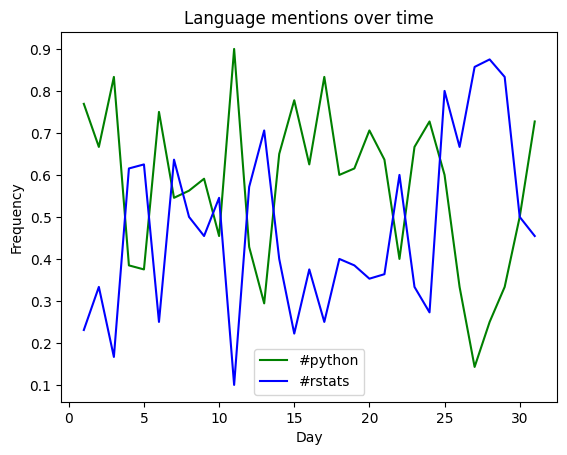

In [27]:
# Plot mean python by day(green)/mean rstats by day(blue)
plt.plot(plot_ix, mean_python, color = 'green')
plt.plot(plot_ix, mean_rstats, color = 'blue')

# Add labels and show
plt.xlabel('Day'); plt.ylabel('Frequency')
plt.title('Language mentions over time')
plt.legend(('#python', '#rstats'))
plt.show()

Loading VADER

Sentiment analysis provides us a small glimpse of the meaning of texts with a rather directly interpretable method. While it has its limitations, it's a good place to begin working with textual data. There's a number of out-of-the-box tools in Python we can use for sentiment analysis.

In [28]:
# Instantiate new SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

# Generate sentiment scores
sentiment_scores = ds_tweets['text'].apply(sid.polarity_scores)

sentiment_scores

created_at
2018-03-30 13:04:22+00:00    {'neg': 0.0, 'neu': 0.85, 'pos': 0.15, 'compou...
2018-03-16 11:59:09+00:00    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
2018-03-27 08:34:33+00:00    {'neg': 0.0, 'neu': 0.864, 'pos': 0.136, 'comp...
2018-03-16 21:26:58+00:00    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
2018-03-15 23:35:05+00:00    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
                                                   ...                        
2018-03-13 08:23:25+00:00    {'neg': 0.0, 'neu': 0.857, 'pos': 0.143, 'comp...
2018-03-03 17:42:59+00:00    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
2018-03-16 07:46:03+00:00    {'neg': 0.184, 'neu': 0.816, 'pos': 0.0, 'comp...
2018-03-25 23:36:39+00:00    {'neg': 0.0, 'neu': 0.896, 'pos': 0.104, 'comp...
2018-03-13 20:04:32+00:00    {'neg': 0.12, 'neu': 0.88, 'pos': 0.0, 'compou...
Name: text, Length: 375, dtype: object

Calculating sentiment scores

A rough measure of sentiment towards a particular hashtag is to measure average sentiment for tweets mentioning a particular hashtag. It's also possible that other things are happening in that tweet, so it's important to inspect both text as well as metrics generated by automated text methods.

In [29]:
sent_val = [sent['compound'] for sent in sentiment_scores.values]
sent_val[:10]

[0.5719, 0.0, 0.4588, 0.0, 0.0, 0.0, 0.0, 0.8074, 0.0, 0.4404]

In [30]:
sent_ts = [sent for sent in sentiment_scores.keys()]
sent_ts[:10]

[Timestamp('2018-03-30 13:04:22+0000', tz='UTC'),
 Timestamp('2018-03-16 11:59:09+0000', tz='UTC'),
 Timestamp('2018-03-27 08:34:33+0000', tz='UTC'),
 Timestamp('2018-03-16 21:26:58+0000', tz='UTC'),
 Timestamp('2018-03-15 23:35:05+0000', tz='UTC'),
 Timestamp('2018-03-25 01:00:25+0000', tz='UTC'),
 Timestamp('2018-03-09 15:59:42+0000', tz='UTC'),
 Timestamp('2018-03-29 08:29:00+0000', tz='UTC'),
 Timestamp('2018-03-24 10:00:53+0000', tz='UTC'),
 Timestamp('2018-03-26 17:04:23+0000', tz='UTC')]

In [31]:
sentiment = pd.Series(index=sent_ts, data=sent_val)
sentiment

2018-03-30 13:04:22+00:00    0.5719
2018-03-16 11:59:09+00:00    0.0000
2018-03-27 08:34:33+00:00    0.4588
2018-03-16 21:26:58+00:00    0.0000
2018-03-15 23:35:05+00:00    0.0000
                              ...  
2018-03-13 08:23:25+00:00    0.3612
2018-03-03 17:42:59+00:00    0.0000
2018-03-16 07:46:03+00:00   -0.4019
2018-03-25 23:36:39+00:00    0.4199
2018-03-13 20:04:32+00:00   -0.3241
Length: 375, dtype: float64

In [32]:
print(ds_tweets[sentiment > 0.6]['text'].values[0])

RT @CMastication: using #Python and #rstats in the same RMarkdown document is pretty awesome with the Reticulate Package. Objects from Pyth…


In [33]:
print(ds_tweets[sentiment < -0.6]['text'].values[0])

RT @DiffusePrioR: Here's the evolution of Irish Population density 1841-&gt;2002 on a DED level. You can see the devastating impact of the Fam…


In [34]:
check_word_in_tweet('#python', ds_tweets)

created_at
2018-03-30 13:04:22+00:00     True
2018-03-16 11:59:09+00:00     True
2018-03-27 08:34:33+00:00    False
2018-03-16 21:26:58+00:00    False
2018-03-15 23:35:05+00:00     True
                             ...  
2018-03-13 08:23:25+00:00    False
2018-03-03 17:42:59+00:00     True
2018-03-16 07:46:03+00:00     True
2018-03-25 23:36:39+00:00    False
2018-03-13 20:04:32+00:00    False
Name: text, Length: 375, dtype: bool

In [35]:
# Generate average sentiment scores for #python
sentiment_py = sentiment[ check_word_in_tweet('#python', ds_tweets) ].resample('1 d').mean()
sentiment_py

2018-03-01 00:00:00+00:00    0.280120
2018-03-02 00:00:00+00:00    0.192238
2018-03-03 00:00:00+00:00    0.136630
2018-03-04 00:00:00+00:00    0.000000
2018-03-05 00:00:00+00:00    0.180233
2018-03-06 00:00:00+00:00    0.221950
2018-03-07 00:00:00+00:00   -0.021100
2018-03-08 00:00:00+00:00    0.269278
2018-03-09 00:00:00+00:00    0.163015
2018-03-10 00:00:00+00:00    0.092540
2018-03-11 00:00:00+00:00    0.221167
2018-03-12 00:00:00+00:00    0.175300
2018-03-13 00:00:00+00:00   -0.045260
2018-03-14 00:00:00+00:00    0.248231
2018-03-15 00:00:00+00:00    0.150400
2018-03-16 00:00:00+00:00   -0.080380
2018-03-17 00:00:00+00:00    0.052440
2018-03-18 00:00:00+00:00    0.000000
2018-03-19 00:00:00+00:00    0.095725
2018-03-20 00:00:00+00:00    0.182258
2018-03-21 00:00:00+00:00    0.215714
2018-03-22 00:00:00+00:00    0.201650
2018-03-23 00:00:00+00:00    0.205388
2018-03-24 00:00:00+00:00    0.175050
2018-03-25 00:00:00+00:00   -0.049033
2018-03-26 00:00:00+00:00    0.164200
2018-03-27 0

In [36]:
# Generate average sentiment scores for #rstats
sentiment_r = sentiment[ check_word_in_tweet('#rstats', ds_tweets) ].resample('1 d').mean()
sentiment_r

2018-03-01 00:00:00+00:00    0.330733
2018-03-02 00:00:00+00:00    0.202500
2018-03-03 00:00:00+00:00    0.000000
2018-03-04 00:00:00+00:00    0.297787
2018-03-05 00:00:00+00:00   -0.071900
2018-03-06 00:00:00+00:00    0.005125
2018-03-07 00:00:00+00:00    0.108457
2018-03-08 00:00:00+00:00    0.182925
2018-03-09 00:00:00+00:00   -0.000250
2018-03-10 00:00:00+00:00   -0.205883
2018-03-11 00:00:00+00:00   -0.648600
2018-03-12 00:00:00+00:00    0.349875
2018-03-13 00:00:00+00:00    0.158042
2018-03-14 00:00:00+00:00    0.278650
2018-03-15 00:00:00+00:00    0.000000
2018-03-16 00:00:00+00:00    0.345533
2018-03-17 00:00:00+00:00    0.146800
2018-03-18 00:00:00+00:00    0.000000
2018-03-19 00:00:00+00:00    0.229760
2018-03-20 00:00:00+00:00    0.321983
2018-03-21 00:00:00+00:00    0.244100
2018-03-22 00:00:00+00:00    0.140150
2018-03-23 00:00:00+00:00    0.283875
2018-03-24 00:00:00+00:00    0.256433
2018-03-25 00:00:00+00:00   -0.061062
2018-03-26 00:00:00+00:00    0.258150
2018-03-27 0

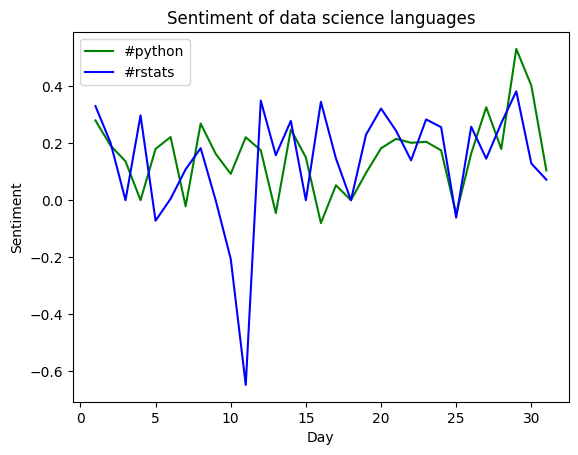

In [37]:
# Plot average #python sentiment per day
plt.plot(sentiment_py.index.day, sentiment_py, color = 'green')

# Plot average #rstats sentiment per day
plt.plot(sentiment_r.index.day, sentiment_r, color = 'blue')

plt.xlabel('Day')
plt.ylabel('Sentiment')
plt.title('Sentiment of data science languages')
plt.legend(('#python', '#rstats'))
plt.show()

Creating retweet network

Social media is, by nature, networked data. Twitter networks manifest in multiple ways. One of the most important types of networks that appear in Twitter are retweet networks. We can represent these as directed graphs, with the retweeting user as the source and the retweeted person as the target. With Twitter data in our flattened DataFrame, we can import these into networkx and create a retweet network.

For this exercise and the rest of this course we'll be using a dataset based on the 2018 State of the Union speech given by Donald Trump

In [38]:
sotu_retweets = pd.read_csv('sotu2018-rt.csv')
sotu_retweets

,contributors,coordinates,created_at,extended_entities,favorite_count,favorited,filter_level,geo,id,id_str,...,retweeted,retweeted_status-extended_tweet-full_text,retweeted_status-text,retweeted_status-user-screen_name,source,text,timestamp_ms,truncated,user-screen_name,withheld_in_countries
0,NaN,NaN,Wed Jan 31 03:51:59 +0000 2018,NaN,0,False,low,NaN,958548390052179968,958548390052179968,...,False,A PERFECT ANALOGY:\n\nSeveral democrats are br...,A PERFECT ANALOGY:\n\nSeveral democrats are br...,ScottPresler,"<a href=""http://twitter.com/download/iphone"" r...",RT @ScottPresler: A PERFECT ANALOGY:\n\nSevera...,1517370719813,False,MatthewJAld,NaN
1,NaN,NaN,Wed Jan 31 03:55:33 +0000 2018,NaN,0,False,low,NaN,958549287285215232,958549287285215232,...,False,NaN,President Trump invited families of Americans ...,RealJack,"<a href=""http://twitter.com/download/android"" ...",RT @RealJack: President Trump invited families...,1517370933730,False,broussard_sr,NaN
2,NaN,NaN,Wed Jan 31 03:09:22 +0000 2018,NaN,0,False,low,NaN,958537665334296577,958537665334296577,...,False,NaN,Don't you be fooled by any of his White Suprem...,UNITEDWEDREAM,"<a href=""http://twitter.com/download/iphone"" r...",RT @UNITEDWEDREAM: Don't you be fooled by any ...,1517368162841,False,CLSTEPHANY,NaN
3,NaN,NaN,Wed Jan 31 02:36:19 +0000 2018,NaN,0,False,low,NaN,958529347828305921,958529347828305921,...,False,NaN,Uh-oh. Our president mentioned the FIRST and S...,TomiLahren,"<a href=""http://twitter.com/download/iphone"" r...",RT @TomiLahren: Uh-oh. Our president mentioned...,1517366179793,False,DAWNSTUTESMAN,NaN
4,NaN,NaN,Wed Jan 31 02:46:24 +0000 2018,NaN,0,False,low,NaN,958531885424173057,958531885424173057,...,False,"Tonight isn't about memos, fake news, free thi...","Tonight isn't about memos, fake news, free thi...",TomiLahren,"<a href=""http://twitter.com/download/android"" ...","RT @TomiLahren: Tonight isn't about memos, fak...",1517366784803,False,SCischk,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2335,NaN,NaN,Wed Jan 31 02:51:31 +0000 2018,NaN,0,False,low,NaN,958533173251538944,958533173251538944,...,False,NaN,"Wow, that portion on the family whose children...",ColumbiaBugle,"<a href=""http://twitter.com/download/iphone"" r...","RT @ColumbiaBugle: Wow, that portion on the fa...",1517367091845,False,_weebutmighty,NaN
2336,NaN,NaN,Wed Jan 31 02:40:54 +0000 2018,NaN,0,False,low,NaN,958530501173628929,958530501173628929,...,False,"Without God, we're destined to fail. ""I can do...","Without God, we're destined to fail. ""I can do...",RedNationRising,"<a href=""http://twitter.com/download/android"" ...","RT @RedNationRising: Without God, we're destin...",1517366454772,False,johnny0nthesp0t,NaN
2337,NaN,NaN,Wed Jan 31 03:04:19 +0000 2018,NaN,0,False,low,NaN,958536393600524288,958536393600524288,...,False,NaN,"Uhhh...""New American Moment"" was a slogan used...",4everNeverTrump,"<a href=""http://twitter.com/download/android"" ...","RT @4everNeverTrump: Uhhh...""New American Mome...",1517367859636,False,joblackwood3,NaN
2338,NaN,NaN,Wed Jan 31 02:42:55 +0000 2018,NaN,0,False,low,NaN,958531008411983878,958531008411983878,...,False,NaN,All the early chatter about whether Trump woul...,HowardKurtz,"<a href=""http://twitter.com/download/android"" ...",RT @HowardKurtz: All the early chatter about w...,1517366575707,False,LindaGarriss,NaN


In [39]:
# Create retweet network from edgelist
G_rt = nx.from_pandas_edgelist(
    sotu_retweets,
    source = 'user-screen_name',
    target = 'retweeted_status-user-screen_name',
    create_using = nx.DiGraph())
 
G_rt

In [40]:
# Print the number of nodes
print('Nodes in RT network:', len(G_rt.nodes()))

# Print the number of edges
print('Edges in RT network:', len(G_rt.edges()))

Nodes in RT network: 2287
Edges in RT network: 2340


Creating reply network

Reply networks have a markedly different structure to retweet networks. While retweet networks often signal agreement, replies can signal discussion, deliberation, and disagreement. The network properties are the same, however: the network is directed, the source is the replier and the target is the user who is being replied to.

In [41]:
sotu_replies = pd.read_csv('sotu2018-reply.csv')
sotu_replies

,contributors,coordinates,created_at,display_text_range,extended_entities,extended_tweet,extended_tweet-full_text,favorite_count,favorited,filter_level,...,quoted_status_id,quoted_status_id_str,reply_count,retweet_count,retweeted,source,text,timestamp_ms,truncated,user-screen_name
0,NaN,NaN,Wed Jan 31 00:21:22 +0000 2018,"[34, 140]",NaN,{'full_text': '@LouDobbs @realDonaldTrump @POT...,@LouDobbs @realDonaldTrump @POTUS Discourage i...,0,False,low,...,9.577015e+17,9.577015e+17,0,0,False,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",@LouDobbs @realDonaldTrump @POTUS Discourage i...,1517358082783,True,ProfessorRobo
1,NaN,NaN,Wed Jan 31 02:42:15 +0000 2018,"[0, 14]",NaN,NaN,NaN,0,False,low,...,9.585300e+17,9.585300e+17,0,0,False,"<a href=""http://twitter.com/download/iphone"" r...",@ChristianMohn https://t.co/WUP9k7DHrm,1517366535591,False,BethMohn
2,NaN,NaN,Tue Jan 30 19:19:49 +0000 2018,"[17, 140]",NaN,{'full_text': '@LarrySchweikart People stay ho...,@LarrySchweikart People stay home to avoid #Fa...,0,False,low,...,NaN,NaN,0,0,False,"<a href=""http://twitter.com/download/android"" ...",@LarrySchweikart People stay home to avoid #Fa...,1517339989113,True,ASilNY
3,NaN,NaN,Tue Jan 30 23:46:17 +0000 2018,"[12, 35]",NaN,NaN,NaN,0,False,low,...,9.584821e+17,9.584821e+17,0,0,False,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",@WhiteHouse https://t.co/WgZvh2L6aT,1517355977521,False,mattg444
4,NaN,NaN,Tue Jan 30 22:21:52 +0000 2018,"[10, 60]",NaN,NaN,NaN,0,False,low,...,NaN,NaN,0,0,False,"<a href=""http://twitter.com/download/iphone"" r...",@aravosis I'm telling you he's practicing Tele...,1517350912194,False,hlthiskrieger
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,NaN,NaN,Tue Jan 30 19:49:19 +0000 2018,"[25, 48]",NaN,NaN,NaN,0,False,low,...,9.581633e+17,9.581633e+17,0,0,False,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",@realDonaldTrump @HHSGov https://t.co/KhbAyDZIN4,1517341759489,False,Dookofurl
1996,NaN,NaN,Wed Jan 31 00:37:30 +0000 2018,"[45, 140]",NaN,"{'full_text': ""@LouDobbs @EdRollins @realDonal...",@LouDobbs @EdRollins @realDonaldTrump @POTUS W...,0,False,low,...,NaN,NaN,0,0,False,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",@LouDobbs @EdRollins @realDonaldTrump @POTUS W...,1517359050990,True,SalMoanella1
1997,NaN,NaN,Wed Jan 31 01:42:00 +0000 2018,NaN,NaN,NaN,NaN,0,False,low,...,NaN,NaN,0,0,False,"<a href=""http://twitter.com/download/iphone"" r...",hey look even tiffany is there it’s really a p...,1517362920342,False,LilPurpleKitty
1998,NaN,NaN,Wed Jan 31 00:04:59 +0000 2018,"[8, 140]",NaN,{'full_text': '@robjh1 Tonight tRump will unve...,@robjh1 Tonight tRump will unveil the Pee Pee ...,0,False,low,...,NaN,NaN,0,0,False,"<a href=""http://twitter.com/#!/download/ipad"" ...",@robjh1 Tonight tRump will unveil the Pee Pee ...,1517357099453,True,barryvernick


In [42]:
# Create reply network from edgelist
G_reply = nx.from_pandas_edgelist(
    sotu_replies,
    source = 'user-screen_name',
    target = 'in_reply_to_screen_name',
    create_using = nx.DiGraph())
    
# Print the number of nodes
print('Nodes in reply network:', len(G_reply.nodes()))

# Print the number of edges
print('Edges in reply network:', len(G_reply.edges()))

Nodes in reply network: 2622
Edges in reply network: 1904


Visualizing retweet network

Visualizing retweets networks is an important exploratory data analysis step because it allows us to visually inspect the structure of the network, understand if there is any user that has disproportionate influence, and if there are different spheres of conversation.

We are going to use a layout which runs quicker to see the plot, but the syntax is nearly the same.

In [43]:
# Create random layout positions
# Each node is assigned a random position in a 2D space, which can then be used to plot the graph using a visualization tool like Matplotlib.

pos = nx.random_layout(G_rt)

list(pos.items())[:10]

[('MatthewJAld', array([0.61754227, 0.91898304], dtype=float32)),
 ('ScottPresler', array([0.3888155 , 0.96702677], dtype=float32)),
 ('broussard_sr', array([0.4921524 , 0.30610394], dtype=float32)),
 ('RealJack', array([0.12267917, 0.41544765], dtype=float32)),
 ('CLSTEPHANY', array([0.19413131, 0.35963792], dtype=float32)),
 ('UNITEDWEDREAM', array([0.31119642, 0.8220103 ], dtype=float32)),
 ('DAWNSTUTESMAN', array([0.874767 , 0.7261215], dtype=float32)),
 ('TomiLahren', array([0.83806074, 0.09409817], dtype=float32)),
 ('SCischk', array([0.99772614, 0.44539475], dtype=float32)),
 ('bceil', array([0.6274703, 0.9365351], dtype=float32))]

In [44]:
[x for x in G_rt.degree()][:10] # The degree of a node is the number of edges connected to it

[('MatthewJAld', 1),
 ('ScottPresler', 68),
 ('broussard_sr', 1),
 ('RealJack', 14),
 ('CLSTEPHANY', 1),
 ('UNITEDWEDREAM', 14),
 ('DAWNSTUTESMAN', 1),
 ('TomiLahren', 45),
 ('SCischk', 1),
 ('bceil', 1)]

In [45]:
# Create size list
sizes = [x[1] for x in G_rt.degree()] # just select the number of edges for each user

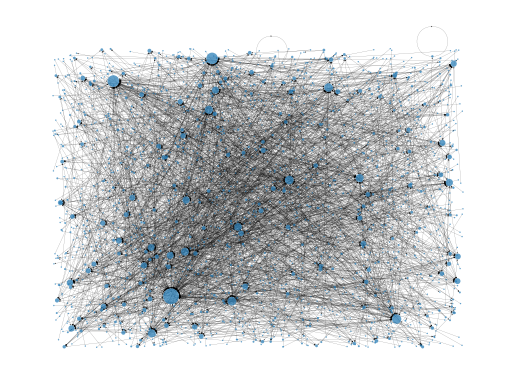

In [46]:
# Draw the network
nx.draw_networkx(G_rt, pos, 
    with_labels = False, 
    node_size = sizes,
    width = 0.1, alpha = 0.7,
    arrowsize = 2, linewidths = 0)

# Turn axis off and show
plt.axis('off')
plt.show()

In-degree centrality

Centrality is a measure of importance of a node to a network. There are many different types of centrality and each of them has slightly different meaning in Twitter networks. We are first focusing on degree centrality, since its calculation is straightforward and has an intuitive explanation.

For directed networks like Twitter, we need to be careful to distinguish between in-degree and out-degree centrality, especially in retweet networks. In-degree centrality for retweet networks signals users who are getting many retweets.

In [47]:
# Generate in-degree centrality for retweets 
rt_centrality = nx.in_degree_centrality(G_rt)
list(rt_centrality.items())[:10]

[('MatthewJAld', 0.0),
 ('ScottPresler', 0.029746281714785654),
 ('broussard_sr', 0.0),
 ('RealJack', 0.006124234470691164),
 ('CLSTEPHANY', 0.0),
 ('UNITEDWEDREAM', 0.006124234470691164),
 ('DAWNSTUTESMAN', 0.0),
 ('TomiLahren', 0.01968503937007874),
 ('SCischk', 0.0),
 ('bceil', 0.0)]

In [48]:
# Generate in-degree centrality for replies 
reply_centrality = nx.in_degree_centrality(G_reply)
list(reply_centrality.items())[:10]

[('ProfessorRobo', 0.00038153376573826786),
 ('BethMohn', 0.0),
 ('ChristianMohn', 0.00038153376573826786),
 ('ASilNY', 0.0),
 ('LarrySchweikart', 0.0011446012972148036),
 ('mattg444', 0.0),
 ('WhiteHouse', 0.011064479206409768),
 ('hlthiskrieger', 0.0),
 ('aravosis', 0.00038153376573826786),
 ('Herky86', 0.0)]

In [49]:
# Store centralities in DataFrame
rt = pd.DataFrame(list(rt_centrality.items()), columns = ['screen_name', 'degree_centrality'])
rt

,screen_name,degree_centrality
0,MatthewJAld,0.000000
1,ScottPresler,0.029746
2,broussard_sr,0.000000
3,RealJack,0.006124
4,CLSTEPHANY,0.000000
...,...,...
2282,DavidLy95971308,0.000000
2283,_weebutmighty,0.000000
2284,johnny0nthesp0t,0.000000
2285,joblackwood3,0.000000


In [50]:
reply = pd.DataFrame(list(reply_centrality.items()), columns = ['screen_name', 'degree_centrality'])
reply

,screen_name,degree_centrality
0,ProfessorRobo,0.000382
1,BethMohn,0.000000
2,ChristianMohn,0.000382
3,ASilNY,0.000000
4,LarrySchweikart,0.001145
...,...,...
2617,indyhawkins,0.000000
2618,Dookofurl,0.000000
2619,LilPurpleKitty,0.000382
2620,robjh1,0.000382


In [51]:
# Print first five results in descending order of centrality
print(rt.sort_values('degree_centrality', ascending = False).head())

      screen_name  degree_centrality
84        FoxNews           0.055993
38     WhiteHouse           0.031059
1    ScottPresler           0.029746
7      TomiLahren           0.019685
175      HouseGOP           0.017060


In [52]:
# Print first five results in descending order of centrality
print(reply.sort_values('degree_centrality', ascending = False).head())

         screen_name  degree_centrality
51   realDonaldTrump           0.057230
53             POTUS           0.019458
22           FoxNews           0.013735
6         WhiteHouse           0.011064
416           FLOTUS           0.010301


Betweenness centrality

Betweenness centrality for retweet and reply networks signals users who bridge between different Twitter communities. These communities may be tied together by topic or ideology.

In [53]:
# Generate betweenness centrality for retweets 
rt_centrality = nx.betweenness_centrality(G_rt)

# Generate betweenness centrality for replies 
reply_centrality = nx.betweenness_centrality(G_reply)

# Store centralities in data frames
rt = pd.DataFrame(list(rt_centrality.items()), columns = ['screen_name', 'betweenness_centrality'])
reply = pd.DataFrame(list(reply_centrality.items()), columns = ['screen_name', 'betweenness_centrality'])

In [54]:
# Print first five results in descending order of centrality
print(rt.sort_values('betweenness_centrality', ascending = False).head())

        screen_name  betweenness_centrality
84          FoxNews                0.000026
29   Public_Citizen                0.000009
206     ChristiChat                0.000005
119      guypbenson                0.000005
362    johncardillo                0.000004


In [55]:
# Print first five results in descending order of centrality
print(reply.sort_values('betweenness_centrality', ascending = False).head())

          screen_name  betweenness_centrality
288      ScottPresler            1.019365e-06
319   HRCNJVolunteers            2.912471e-07
1109             RRN3            2.912471e-07
1697    thebestcloser            2.912471e-07
1844   BrandonTXNeely            1.456236e-07


Ratios

While not strictly a measure of importance to a network, the idea of being "ratio'd" is a network measure which is particular to Twitter and is typically used to judge the unpopularity of a tweet. "The Ratio," as it is called, is calculated by taking the number of replies and dividing it by the number of retweets. For our purposes, it makes conceptual sense to take only the in-degrees of both the retweet and reply networks.

In [56]:
list(G_rt.in_degree())[:10] #  the in-degree is the count of retweets directed towards the node

[('MatthewJAld', 0),
 ('ScottPresler', 68),
 ('broussard_sr', 0),
 ('RealJack', 14),
 ('CLSTEPHANY', 0),
 ('UNITEDWEDREAM', 14),
 ('DAWNSTUTESMAN', 0),
 ('TomiLahren', 45),
 ('SCischk', 0),
 ('bceil', 0)]

In [57]:
list(G_reply.in_degree())[:10] # the in-degree is the count of replies directed towards the node

[('ProfessorRobo', 1),
 ('BethMohn', 0),
 ('ChristianMohn', 1),
 ('ASilNY', 0),
 ('LarrySchweikart', 3),
 ('mattg444', 0),
 ('WhiteHouse', 29),
 ('hlthiskrieger', 0),
 ('aravosis', 1),
 ('Herky86', 0)]

In [58]:
# Calculate in-degrees and store in DataFrame
degree_rt = pd.DataFrame(list(G_rt.in_degree()), columns = ['screen_name', 'degree'])
degree_reply = pd.DataFrame(list(G_reply.in_degree()), columns = ['screen_name', 'degree'])

# Merge the two DataFrames on screen name
ratio = degree_rt.merge(degree_reply, on = 'screen_name', suffixes = ('_rt', '_reply'))
ratio


,screen_name,degree_rt,degree_reply
0,ScottPresler,68,7
1,RealJack,14,2
2,TomiLahren,45,4
3,glennbeck,12,1
4,PressSec,8,3
...,...,...,...
111,fatherhoops,0,0
112,MarkSimoneNY,1,2
113,lilkadel,0,1
114,candylotus,1,1


In [59]:
# Calculate the ratio
ratio['ratio'] = ratio['degree_reply'] / ratio['degree_rt']

# Exclude any tweets with less than 5 retweets
ratio = ratio[ratio['degree_rt'] >= 5]

# Print out first five with highest ratio
print(ratio.sort_values('ratio', ascending = False).head())

       screen_name  degree_rt  degree_reply  ratio
46     SpeakerRyan          8            15  1.875
53         NBCNews         20            18  0.900
43      benshapiro          5             4  0.800
42       SenateGOP          5             3  0.600
85  CBSThisMorning          6             3  0.500


Accessing user-defined location

In the slides, we saw that we could obtain user location via user-generated text, including the tweet itself and the location field in the user's description. These are the two most imprecise methods of obtaining user location, but also possibly more readily available.

In this exercise, you're going extract the user-defined location from a single example tweet as well as a large set of tweets. We've added another line to our flatten_tweets() function which will allow you to access user-defined location within the data frame.

In [60]:
tweets_sotu_json = save_and_load_json(json_file = 'tweets_sotu_json.json', json_dict=False, to_dict=False)

In [61]:
# Print out the location of a single tweet
print(tweet['user']['location'])

Toronto, ON


In [62]:
# Flatten and load the SOTU tweets into a dataframe
tweets_sotu = pd.DataFrame(flatten_tweets(tweets_sotu_json))
tweets_sotu

,created_at,id,id_str,text,display_text_range,source,truncated,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,...,filter_level,lang,timestamp_ms,user-screen_name,quoted_status-text,quoted_status-extended_tweet-full_text,user-location,extended_tweet,extended_tweet-full_text,extended_entities
0,Wed Jan 31 02:07:51 +0000 2018,958522184518873088,958522184518873088,Dumb ass mother fucker https://t.co/UpMmRjKHYR,"[0, 22]","<a href=""http://twitter.com/download/iphone"" r...",False,NaN,None,NaN,...,low,en,1517364471927,_justinbordelon,"In Davos, @realDonaldTrump downplayed climate ...","In Davos, @realDonaldTrump downplayed climate ...",We out here,NaN,NaN,NaN
1,Wed Jan 31 03:11:01 +0000 2018,958538079593205761,958538079593205761,Mic Drop! #SOTU https://t.co/CEIwcZA7CG,"[0, 15]","<a href=""http://twitter.com/download/android"" ...",False,NaN,None,NaN,...,low,en,1517368261608,dilypres,This is the longest SNL cold open ever. #SOTU,NaN,"Halifax, NS, Canada",NaN,NaN,NaN
2,Wed Jan 31 02:49:21 +0000 2018,958532627408957440,958532627408957440,WTF? Trump just said he supports paid family l...,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,NaN,None,NaN,...,low,en,1517366961706,benj_fry,NaN,NaN,"San Francisco, CA",NaN,NaN,NaN
3,Wed Jan 31 03:02:36 +0000 2018,958535961901596672,958535961901596672,"Give me your worthy, your best, your educated ...",NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,NaN,None,NaN,...,low,en,1517367756711,Maxeek,NaN,NaN,"Los Angeles, CA",NaN,NaN,NaN
4,Wed Jan 31 03:21:54 +0000 2018,958540819287326721,958540819287326721,I'm so glad I skipped out in this shit show. W...,NaN,"<a href=""http://twitter.com/download/android"" ...",True,NaN,None,NaN,...,low,en,1517368914802,Parth_Dave,NaN,NaN,"Los Angeles, CA",{'full_text': 'I'm so glad I skipped out in th...,I'm so glad I skipped out in this shit show. W...,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
530,Wed Jan 31 02:47:09 +0000 2018,958532073559592960,958532073559592960,Bernie Sanders face though #SOTU,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,NaN,None,NaN,...,low,en,1517366829658,jesssuggswx,NaN,NaN,None,NaN,NaN,NaN
531,Wed Jan 31 02:38:31 +0000 2018,958529901178556416,958529901178556416,We are one of the only countries that refuses ...,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,NaN,None,NaN,...,low,en,1517366311722,georgefayner,NaN,NaN,"Cleveland, OH",NaN,NaN,NaN
532,Wed Jan 31 02:06:02 +0000 2018,958521727155425280,958521727155425280,"Having been to two #SOTU addresses myself, it’...",NaN,"<a href=""http://twitter.com/download/iphone"" r...",True,NaN,None,NaN,...,low,en,1517364362883,PaulRieckhoff,NaN,NaN,NYC to the fullest,{'full_text': 'Having been to two #SOTU addres...,"Having been to two #SOTU addresses myself, it’...",NaN
533,Wed Jan 31 02:04:12 +0000 2018,958521265974898688,958521265974898688,"I just saw the intro to #SOTU, I saw Trump’s f...",NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,NaN,None,NaN,...,low,en,1517364252929,ariellefrank,NaN,NaN,"Orlando, FL",NaN,NaN,NaN


In [63]:
tweets_sotu['user-location'].value_counts()

user-location
Washington, DC                    20
Los Angeles, CA                   13
New York, NY                      11
Brooklyn, NY                       8
San Francisco, CA                  7
                                  ..
Baltimore, MD ✈️ Atlanta, GA       1
Bowling Green State University     1
Argentina                          1
Houston, TX                        1
NYC to the fullest                 1
Name: count, Length: 333, dtype: int64

Accessing bounding box

Most tweets which have coordinate-level geographical information attached to them typically come in the form of a bounding box. Bounding boxes are a set of four longitudinal/latitudinal coordinates which denote a particular area in which the user can be located. The bounding box is located in the place value of the Twitter JSON.

In [65]:
tweets_sotu.place[0]

{'id': '1c73ebb264e145ee',
 'url': 'https://api.twitter.com/1.1/geo/id/1c73ebb264e145ee.json',
 'place_type': 'admin',
 'name': 'Louisiana',
 'full_name': 'Louisiana, USA',
 'country_code': 'US',
 'country': 'United States',
 'bounding_box': {'type': 'Polygon',
  'coordinates': [[[-94.043628, 28.855128],
    [-94.043628, 33.019544],
    [-88.758389, 33.019544],
    [-88.758389, 28.855128]]]},
 'attributes': {}}

In [71]:
def getBoundingBox(place):
    """ Returns the bounding box coordinates."""
    return place['bounding_box']['coordinates'][0] # [0] just to reduce dimensionality of the list

In [72]:
# Apply the function which gets bounding box coordinates
bounding_boxes = tweets_sotu['place'].apply(getBoundingBox)
bounding_boxes[0]

[[-94.043628, 28.855128],
 [-94.043628, 33.019544],
 [-88.758389, 33.019544],
 [-88.758389, 28.855128]]

Calculating the centroid

The bounding box can range from a city block to a whole state or even country. For simplicity's sake, one way we can deal with handling these data is by translating the bounding box into what's called a centroid, or the center of the bounding box. The calculation of the centroid is straight forward -- we calculate the midpoints of the lines created by the latitude and longitudes.

In [74]:
def calculateCentroid(place):
    """ Calculates the centroid from a bounding box."""
    # Obtain the coordinates from the bounding box.
    coordinates = place['bounding_box']['coordinates'][0]
        
    longs = np.unique( [x[0] for x in coordinates] )
    lats  = np.unique( [x[1] for x in coordinates] )

    if len(longs) == 1 and len(lats) == 1:
        # return a single coordinate
        return (longs[0], lats[0])
    elif len(longs) == 2 and len(lats) == 2:
        # If we have two longs and lats, we have a box.
        central_long = np.sum(longs) / 2
        central_lat  = np.sum(lats) / 2
    else:
        raise ValueError("Non-rectangular polygon not supported: %s" % 
            ",".join(map(lambda x: str(x), coordinates)) )

    return (central_long, central_lat)

In [75]:
# Calculate the centroids of place     
centroids = tweets_sotu['place'].apply(calculateCentroid)
centroids

0       (-91.40100849999999, 30.937336000000002)
1      (-61.811730499999996, 44.321234000000004)
2                     (-122.4359785, 37.7706565)
3                     (-118.4119065, 34.0207895)
4                      (-118.136676, 34.0855965)
                         ...                    
530                      (-80.428864, 37.229291)
531                    (-81.4212215, 41.3863935)
532                     (-73.9685415, 40.780709)
533             (-81.491811, 28.457142500000003)
534              (-97.71558250000001, 26.196365)
Name: place, Length: 535, dtype: object

Creating Basemap map

Basemap allows you to create maps in Python. The library builds projections for latitude and longitude coordinates and then passes the plotting work on to matplotlib. This means you can build extra features based on the power of matplotlib.

In this exercise, we're going to set up a map of the continental United States on a Mercator projection.

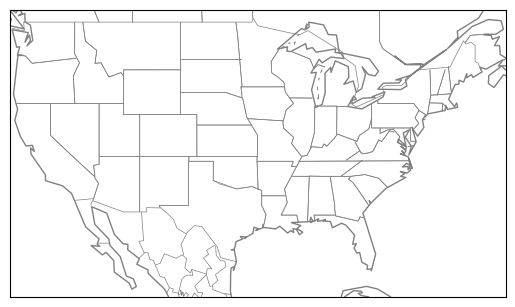

In [84]:
# Set up the US bounding box
us_boundingbox = [-125, 22, -64, 50] 

# Set up the Basemap object
m = Basemap(llcrnrlon = us_boundingbox[0],
            llcrnrlat = us_boundingbox[1],
            urcrnrlon = us_boundingbox[2],
            urcrnrlat = us_boundingbox[3],
            projection='merc')

# Draw continents in white,
# coastlines and countries in gray
m.fillcontinents(color='white')
m.drawcoastlines(color='gray')
m.drawcountries(color='gray')

# Draw the states and show the plot
m.drawstates(color='gray')
plt.show()

Plotting centroid coordinates

Because we can't plot whole bounding boxes, we summarize the bounding box location into a single point called a centroid. Plotting these on a Basemap map is straightforward. Once we calculate the centroids, we separate the longitudes and latitudes, then pass to the .scatter() method.

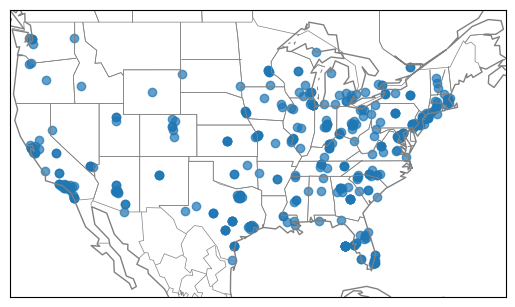

In [81]:
# Calculate the centroids for the dataset
# and isolate longitudue and latitudes
centroids = tweets_sotu['place'].apply(calculateCentroid)
lon = [x[0] for x in centroids]
lat = [x[1] for x in centroids]

# Draw continents, coastlines, countries, and states
m.fillcontinents(color='white', zorder = 0)
m.drawcoastlines(color='gray')
m.drawcountries(color='gray')
m.drawstates(color='gray')

# Draw the points and show the plot
m.scatter(lon, lat, latlon = True, alpha = 0.7)
plt.show()

Coloring by sentiment

We want to be able to differentiate by place with our Twitter analysis. One distinguishing factor between places is how the State of the Union speech was received. For this purpose, we'll use the sentiment analysis we covered in Chapter 2 to evaluate how the speech was received in different parts of the country.

In [87]:
# Generate sentiment scores
sentiment_scores = tweets_sotu['text'].apply(sid.polarity_scores)

# Isolate the compound element
sentiment_scores = [x['compound'] for x in sentiment_scores]

sentiment_scores[:10]

[-0.9022, -0.3382, -0.8012, 0.8225, -0.6915, -0.6114, 0.2732, 0.0, 0.0, 0.2263]

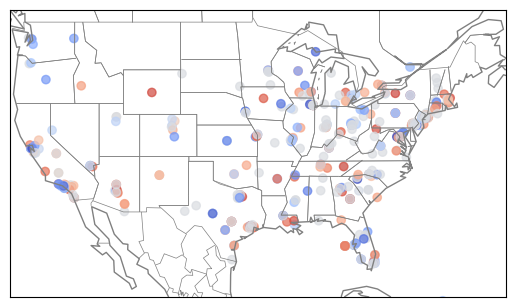

In [88]:
# Draw continents, coastlines, countries, and states
m.fillcontinents(color='white', zorder = 0)
m.drawcoastlines(color='gray')
m.drawcountries(color='gray')
m.drawstates(color='gray')

# Draw the points
m.scatter(lon, lat, latlon = True, c = sentiment_scores, cmap =  'coolwarm', alpha = 0.7)

# Show the plot
plt.show()